In [1]:
import math
import os
import time
import json
from pathlib import Path
from typing import Literal, Optional

import numpy as np
import torch
from PIL import Image
from torch import Tensor, optim

from gsplat import rasterization, rasterization_2dgs
from dataclasses import dataclass, field
from typing import Dict, List, Optional, Tuple, Union
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure
import matplotlib.pyplot as plt
import os
from IPython.display import display, clear_output
import torch.nn.functional as F
from diffusers import DiffusionPipeline

/home/nskochetkov/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
@dataclass
class Config:
    width: int = 256
    height: int = 256
    num_points: int = 100_000
    save_imgs: bool = True
    iterations: int = 1_000
    lr: float = 0.01
    model_type: Literal["3dgs", "2dgs"] = "3dgs"
    save_steps: List[int] = field(default_factory=lambda: [7_000, 30_000])
    img_path: str = ""
    ckpt_path: str = ""
    results_dir: str = "results_2d"
    show_steps: int = 10
    use_sds_loss: bool = False
    use_fused_loss: bool = False
    lmbd : float = 1.0
    save_images: bool = False
    patch_image: bool = False
    batch_size: int = 64
    # noise level for conditional image
    lowres_noise_level: float = 0.75
    # minimum step for forward diffusion process
    min_noise_step: int = 20
    # maximum step for forward diffusion process
    max_noise_step: int = 980
    # instead randomly sampling noise we can
    # linearly changing applied noise
    use_noise_scheduler: bool = False
    show_plots : bool = True
    

In [3]:
class SDSLoss3DGS(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # load the model
        self.device = torch.device("cuda:0")

        # this is to make it work on the cluster as it does not have internet access to download the model
        deepfloyd_sr_model_path = "/home/nskochetkov/.cache/huggingface/hub/models--DeepFloyd--IF-II-L-v1.0/snapshots/609476ce702b2d94aff7d1f944dcc54d4f972901"
        pipe = DiffusionPipeline.from_pretrained(
            deepfloyd_sr_model_path,
            # text_encoder=None,
            safety_checker=None,
            watermarker=None,
            feature_extractor=None,
            requires_safety_checker=False,
            variant="fp16",
            torch_dtype=torch.float16,
        ).to(self.device)

        self.unet = pipe.unet.eval()
        self.scheduler = pipe.scheduler
        self.num_train_timesteps = self.scheduler.config.num_train_timesteps
        self.alphas = self.scheduler.alphas_cumprod.to(self.device)
        self.prompt_embeddings = pipe.encode_prompt("")

    @torch.amp.autocast("cuda", enabled=False)
    def forward_unet(self, latents, t, encoder_hidden_states, **kwargs):
        input_dtype = latents.dtype
        return self.unet(
            latents.to(torch.float16),
            t.to(torch.float16),
            encoder_hidden_states=encoder_hidden_states.to(torch.float16),
            **kwargs,
        ).sample.to(input_dtype)

    def prepare_latents(self, images):
        resolution = (256, 256)
        latents = F.interpolate(
            images, resolution, mode="bilinear", align_corners=False, antialias=True
        )
        return 2.0 * latents - 1.0

    def prepare_downscaled_latents(self, images, lowres_noise_level):
        # downscaled = F.interpolate(
        #    images, (64, 64), mode="nearest"
        # )  # , align_corners=False, antialias=True)
        upscaled = F.interpolate(
            images, (256, 256), mode="nearest"
        )  # , align_corners=True).detach()
        upscaled = 2.0 * upscaled - 1.0
        upscaled = self.scheduler.add_noise(
            upscaled,
            torch.randn_like(upscaled),
            torch.tensor(int(self.num_train_timesteps * lowres_noise_level)),
        )
        return upscaled

    def construct_gradient(self, noise_pred, noise, t, guidance_scale):
        noise_pred_text, noise_pred_uncond = noise_pred.chunk(2)
        noise_pred_text, _ = noise_pred_text.split(3, dim=1)
        noise_pred_uncond, _ = noise_pred_uncond.split(3, dim=1)
        noise_pred = noise_pred_text + guidance_scale * (
            noise_pred_text - noise_pred_uncond
        )

        w = (1 - self.alphas[t]).view(-1, 1, 1, 1)
        # w = w * (1 - w) ** 0.5
        grad = w * (noise_pred - noise)
        grad = torch.nan_to_num(grad)
        return grad

    def forward(
        self,
        images,
        original,
        min_step=20,
        max_step=980,
        guidance_scale=10.0,
        lowres_noise_level=0.75,
        scheduler_timestep=None,
    ):
        # prepare images
        batch_size = images.shape[0]
        # positive and negative embeddings
        batch_embeddings = [
            self.prompt_embeddings[0].repeat(batch_size, 1, 1),
            self.prompt_embeddings[1].repeat(batch_size, 1, 1),
        ]

        latents = self.prepare_latents(images)

        condition = original
        condition = self.prepare_downscaled_latents(condition, lowres_noise_level)
        noise_level = torch.full(
            [2 * condition.shape[0]],
            torch.tensor(int(self.num_train_timesteps * lowres_noise_level)),
            device=condition.device,
        )

        if scheduler_timestep is not None:
            t = scheduler_timestep * torch.ones(
                batch_size, dtype=torch.long, device=self.device
            )
        else:
            # sample ts
            t = torch.randint(
                min_step, max_step, [batch_size], dtype=torch.long, device=self.device
            )

        # predict noise
        with torch.no_grad():
            noise = torch.randn_like(latents, device=self.device)
            latents_noisy = self.scheduler.add_noise(latents, noise, t)

            latents_noisy = torch.cat([latents_noisy, condition], dim=1)

            latents_noisy = self.scheduler.scale_model_input(latents_noisy, t)
            noise_pred = self.forward_unet(
                torch.cat(2 * [latents_noisy]),
                torch.cat(2 * [t]),
                torch.cat(batch_embeddings),
                class_labels=noise_level,
            )
        # convert noise prediction into gradient
        grad = self.construct_gradient(noise_pred, noise, t, guidance_scale)
        # compute surrogate loss
        target = (latents - grad).detach()
        loss_sds = 0.5 * F.mse_loss(latents, target, reduction="sum") / batch_size
        return loss_sds

In [4]:
def image2patches(image, patch_size):
    channels, H, W = image.shape
    pad_h = (patch_size - H % patch_size) % patch_size  # Padding needed for height
    pad_w = (patch_size - W % patch_size) % patch_size  # Padding needed for width

    # Pad the tensor
    padded_tensor = F.pad(
        image, 
        (0, pad_w, 0, pad_h),  # Pad in the order (W_left, W_right, H_top, H_bottom)
        mode="constant",
        value=0
    )

    # Compute the number of patches along each dimension
    H_padded, W_padded = padded_tensor.shape[1], padded_tensor.shape[2]
    num_patches_h = H_padded // patch_size
    num_patches_w = W_padded // patch_size

    # Extract patches
    patches = []
    for i in range(num_patches_h):
        for j in range(num_patches_w):
            patch = padded_tensor[:, i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]
            patches.append(patch)

    # Convert the list of patches into a single tensor
    patches = torch.stack(patches)  # Shape: [num_patches, 3, 64, 64]
    #print(f"Extracted {patches.shape[0]} patches with shape {patches.shape[1:]}")
    return patches

In [5]:
# need to create a data loader and dataset
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as VF
from PIL import Image

class OneImageDataset(Dataset):
    def __init__(self, image_path, patch_size=64, dataset_len=1000, resize=True, train=True):
        super().__init__()
        self.train = train
        
        self.len = dataset_len
        self.img = Image.open(image_path)
        if resize:
            self.img = self.img.resize((256, 256))
        to_tensor = transforms.ToTensor()
        self.img = to_tensor(self.img)
        self.patch_size = patch_size
        self.training_img = None

    def __getitem__(self, idx):
        # C, H, W -> H, W, C
        i, j, h, w = transforms.RandomCrop.get_params(self.img, output_size=(self.patch_size, self.patch_size))
        if self.train:
            patch_real = VF.crop(self.img, i, j, h, w).permute(1, 2, 0)
            patch_pred = VF.crop(self.training_img, i, j, h, w).permute(1, 2, 0)
            return patch_pred, patch_real
        # training img already in correct shape
        return self.training_img, self.img.permute(1, 2, 0)

    def __len__(self):
        return self.len if self.train else 1

In [6]:
#one_image_dataset = OneImageDataset(image_path="/home/kolek/Edu/thesis/sds_guided_3dgs/data/360_v2/bicycle/images_8/_DSC8679.JPG")

In [7]:
# train_img = torch.zeros(256, 256, 3)
# one_image_dataset.set_training_img(train_img)
# pred, real = one_image_dataset[0]

# plt.imshow((real.numpy() * 255).astype(np.uint8))

In [8]:
# pred.shape, real.shape

In [9]:
class SimpleTrainer:
    """Trains random gaussians to fit an image."""

    def __init__(
        self,
        cfg: Config = Config()
    ):
        self.cfg = cfg
        self.device = torch.device("cuda:0")
        self.one_image_dataset = OneImageDataset(image_path=cfg.img_path)
        self.num_points = self.cfg.num_points
        self.iter = 0
        self.frames = []
        self.ckpt_dir = f"{self.cfg.results_dir}/ckpts"
        os.makedirs(self.ckpt_dir, exist_ok=True)
        self.stats_dir = f"{self.cfg.results_dir}/stats"
        os.makedirs(self.stats_dir, exist_ok=True)
        self.render_dir = f"{self.cfg.results_dir}/renders"
        os.makedirs(self.render_dir, exist_ok=True)

        self.psnr = PeakSignalNoiseRatio(data_range=1.0).to(self.device)

        fov_x = math.pi / 2.0
        self.H, self.W = self.one_image_dataset.img.size(1), self.one_image_dataset.img.size(2)
        self.focal = 0.5 * float(self.W) / math.tan(0.5 * fov_x)
        self.img_size = torch.tensor([self.W, self.H, 1], device=self.device)

        if self.cfg.ckpt_path:
            self._load_gaussians(self.cfg.ckpt_path)
        else:
            self._init_gaussians()

        self.optimizer = optim.Adam(
            [self.rgbs, self.means, self.scales, self.opacities, self.quats], self.cfg.lr
        )

        if self.cfg.ckpt_path:
            self.optimizer.load_state_dict(self.optimizer_state_dict)
        if self.cfg.use_sds_loss:
            self.sds_loss = SDSLoss3DGS()
            self.dataloader = DataLoader(self.one_image_dataset, batch_size=cfg.batch_size, num_workers=0)
        self.mse_loss = torch.nn.MSELoss()

    def _load_gaussians(self, ckpt_path):
        ckpt = torch.load(ckpt_path, weights_only=False)
        print(f"Loading checkpoint {ckpt_path}")
        self.opacities = ckpt["opacities"]
        self.quats = ckpt["quats"]
        self.rgbs = ckpt["rgbs"]
        self.scales = ckpt["scales"]
        self.means = ckpt["means"]
        self.iter = ckpt["iter"]
        self.frames = ckpt["frames"]

        self.optimizer_state_dict = ckpt["optimizer"]
        self.viewmat = torch.tensor(
            [
                [1.0, 0.0, 0.0, 0.0],
                [0.0, 1.0, 0.0, 0.0],
                [0.0, 0.0, 1.0, 8.0],
                [0.0, 0.0, 0.0, 1.0],
            ],
            device=self.device,
        )

    def _init_gaussians(self):
        """Random gaussians"""
        bd = 2

        self.means = bd * (torch.rand(self.num_points, 3, device=self.device) - 0.5)
        self.scales = torch.rand(self.num_points, 3, device=self.device)
        d = 3
        self.rgbs = torch.rand(self.num_points, d, device=self.device)

        u = torch.rand(self.num_points, 1, device=self.device)
        v = torch.rand(self.num_points, 1, device=self.device)
        w = torch.rand(self.num_points, 1, device=self.device)

        self.quats = torch.cat(
            [
                torch.sqrt(1.0 - u) * torch.sin(2.0 * math.pi * v),
                torch.sqrt(1.0 - u) * torch.cos(2.0 * math.pi * v),
                torch.sqrt(u) * torch.sin(2.0 * math.pi * w),
                torch.sqrt(u) * torch.cos(2.0 * math.pi * w),
            ],
            -1,
        )
        self.opacities = torch.ones((self.num_points), device=self.device)

        self.viewmat = torch.tensor(
            [
                [1.0, 0.0, 0.0, 0.0],
                [0.0, 1.0, 0.0, 0.0],
                [0.0, 0.0, 1.0, 8.0],
                [0.0, 0.0, 0.0, 1.0],
            ],
            device=self.device,
        )
        self.background = torch.zeros(d, device=self.device)

        self.means.requires_grad = True
        self.scales.requires_grad = True
        self.quats.requires_grad = True
        self.rgbs.requires_grad = True
        self.opacities.requires_grad = True
        self.viewmat.requires_grad = False
    
    # Calculate gradient norm from optimizer's parameters
    def calculate_grad_norm(self):
        total_norm = 0.0
        for param_group in self.optimizer.param_groups:
            for param in param_group['params']:
                if param.grad is not None:  # Check if gradient exists
                    param_norm = param.grad.norm(2)  # L2 norm of the gradient
                    total_norm += param_norm.item() ** 2
        return total_norm ** 0.5  # Return the overall gradient norm

    def train(self):
        frames = self.frames
        times = [0] * 2  # rasterization, backward
        K = torch.tensor(
            [
                [self.focal, 0, self.W / 2],
                [0, self.focal, self.H / 2],
                [0, 0, 1],
            ],
            device=self.device,
        )

        if self.cfg.model_type == "3dgs":
            rasterize_fnc = rasterization
        elif self.cfg.model_type == "2dgs":
            rasterize_fnc = rasterization_2dgs

        begin = self.iter
        end = begin + self.cfg.iterations
        losses = []
        psnrs = []
        grad_norms = []
        self.one_image_dataset.img = self.one_image_dataset.img.to(self.device)
        scheduler_timestep = None
        for i in range(begin, end):
            start = time.time()

            renders = rasterize_fnc(
                self.means,
                self.quats / self.quats.norm(dim=-1, keepdim=True),
                self.scales,
                torch.sigmoid(self.opacities),
                torch.sigmoid(self.rgbs),
                self.viewmat[None],
                K[None],
                self.W,
                self.H,
                packed=False,
            )[0]
            out_img = renders[0]
            torch.cuda.synchronize()
            times[0] += time.time() - start
            # calculate loss
            mse_loss = self.mse_loss(out_img, self.one_image_dataset.img.permute(1, 2, 0))

            if self.cfg.use_sds_loss:
                # H, W, C -> C, H, W
                self.dataloader.dataset.training_img = out_img.permute(2, 0, 1)
                pred, real = next(iter(self.dataloader))
                pred = pred.to(self.device)
                real = real.to(self.device)
                sds = self.sds_loss(images=pred.permute(0, 3, 1, 2),
                                    original=real.permute(0, 3, 1, 2),
                                    min_step=self.cfg.min_noise_step,
                                    max_step=self.cfg.max_noise_step,
                                    lowres_noise_level=self.cfg.lowres_noise_level,
                                    scheduler_timestep=scheduler_timestep)
            
            if self.cfg.use_fused_loss and self.cfg.use_sds_loss:
                loss = mse_loss + sds
            elif self.cfg.use_sds_loss:
                loss = sds
            else:
                loss = mse_loss
            
            
            self.optimizer.zero_grad()
            start = time.time()
            loss.backward()
            torch.cuda.synchronize()
            times[1] += time.time() - start
            self.optimizer.step()
            psnr = self.psnr(out_img, self.one_image_dataset.img.permute(1, 2, 0))
            grad_norm = self.calculate_grad_norm()
            losses.append(loss.item())
            psnrs.append(psnr.item())
            grad_norms.append(grad_norm.item())
            print(
                f"Iteration {i + 1}/{end}, Loss: {loss.item()}, PSNR: {psnr.item()}"
            )

            if i % self.cfg.show_steps == 0:
                clear_output(wait=True)
                pred = (out_img.detach().cpu().numpy() * 255).astype(np.uint8)
                orig = (self.one_image_dataset.img.permute(1, 2, 0).detach().cpu().numpy() * 255).astype(np.uint8)
                # Create the figure with additional row for gradient norm plot
                fig, axes = plt.subplots(3, 2, figsize=(12, 15))

                # Plot 1: Original Image
                axes[0, 0].imshow(orig)
                axes[0, 0].set_title("Original Image")
                axes[0, 0].axis('off')

                # Plot 2: Predicted Image
                axes[0, 1].imshow(pred)
                axes[0, 1].set_title("Predicted Image")
                axes[0, 1].axis('off')

                # Plot 3: PSNR Evolution
                axes[1, 0].plot(psnrs, label='PSNR')
                axes[1, 0].set_title("PSNR")
                axes[1, 0].set_xlabel("Epoch")
                axes[1, 0].set_ylabel("PSNR (dB)")
                axes[1, 0].grid(True)
                axes[1, 0].legend()

                # Plot 4: Loss Evolution
                axes[1, 1].plot(losses, label='Loss', color='red')
                axes[1, 1].set_title("Loss")
                axes[1, 1].set_xlabel("Epoch")
                axes[1, 1].set_ylabel("Loss")
                axes[1, 1].grid(True)
                axes[1, 1].legend()

                # Plot 5: Gradient Norm Evolution
                axes[2, 0].plot(grad_norms, label='Gradient Norm', color='purple')
                axes[2, 0].set_title("Gradient Norm")
                axes[2, 0].set_xlabel("Epoch")
                axes[2, 0].set_ylabel("Gradient Norm")
                axes[2, 0].grid(True)
                axes[2, 0].legend()

                # Hide the last unused subplot (bottom-right corner)
                axes[2, 1].axis('off')
                plt.savefig(f"{self.stats_dir}/training_plots.png", dpi=300, bbox_inches='tight')
                if self.cfg.save_imgs:
                    frames.append(pred)
            if i in [idx - 1 for idx in self.cfg.save_steps] or i == end - 1:
                print(f"Saving checkpoint at: {i}")
                to_save = {
                    "optimizer": self.optimizer.state_dict(),
                    "iter": iter,
                    "means": self.means,
                    "quats": self.quats,
                    "opacities": self.opacities,
                    "rgbs": self.rgbs,
                    "scales": self.scales,
                    "frames": frames,
                }
                frame = (out_img.detach().cpu().numpy() * 255).astype(np.uint8)
                # also save the last rendering
                Image.fromarray(frame).save(f"{self.render_dir}/image_{i}.png")
                torch.save(to_save, f"{self.ckpt_dir}/ckpt_{i}.pt")
                with open(f"{self.stats_dir}/step{i}.json", "w") as f:
                    json.dump({"psnr": psnr.item()}, f)

        if self.cfg.save_imgs:
            # save them as a gif with PIL
            frames = [Image.fromarray(frame) for frame in frames]
            frames[0].save(
                f"{self.render_dir}/training.gif",
                save_all=True,
                append_images=frames[1:],
                optimize=False,
                duration=5,
                loop=0,
            )
        print(f"Total(s):\nRasterization: {times[0]:.3f}, Backward: {times[1]:.3f}")
        print(
            f"Per step(s):\nRasterization: {times[0]/self.cfg.iterations:.5f}, Backward: {times[1]/self.cfg.iterations:.5f}"
        )


In [10]:
! nvidia-smi

Tue Jan 21 03:51:25 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.86.10              Driver Version: 535.86.10    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-32GB           On  | 00000000:1A:00.0 Off |                    0 |
| N/A   40C    P0              43W / 300W |      3MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [11]:
import gc
gc.collect()
torch.cuda.empty_cache()

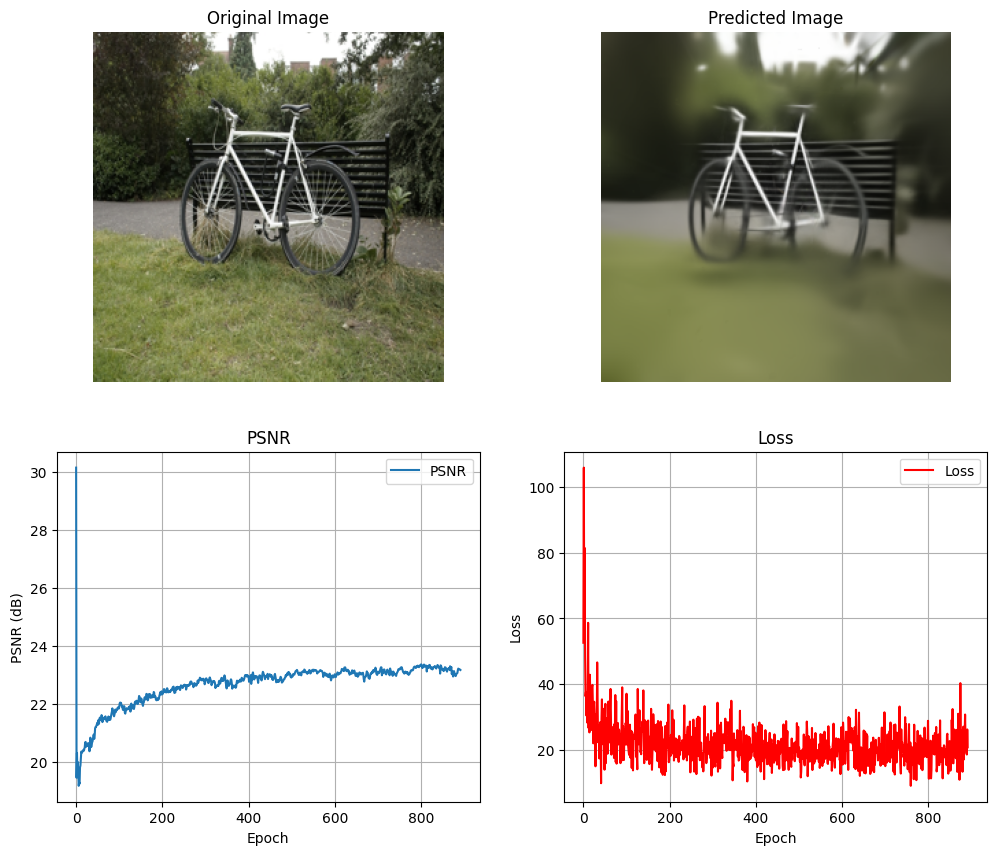

Iteration 30892/30999, Loss: 17.446779251098633, PSNR: 23.19601821899414
Iteration 30893/30999, Loss: 9.082403182983398, PSNR: 23.146947860717773
Iteration 30894/30999, Loss: 16.23912811279297, PSNR: 23.045141220092773
Iteration 30895/30999, Loss: 18.892112731933594, PSNR: 23.023378372192383
Iteration 30896/30999, Loss: 21.874481201171875, PSNR: 23.037282943725586


In [ ]:
# NEW
# now let's perform experiments with 7000 iterations with
# sds loss but without patches, learning rate will be 1e-6, much smaller then for basic splats learning
cfg = Config()
checkpoint_iters = 29999
cfg.img_path = "/home/nskochetkov/sds_guided_3dgs/data/360_v2/bicycle/images_8/_DSC8679.JPG"
cfg.ckpt_path = f"/home/nskochetkov/sds_guided_3dgs/results_2d/ckpts/ckpt_{checkpoint_iters}.pt"
cfg.iterations = 1_000
cfg.use_sds_loss = True
cfg.batch_size = 32
cfg.results_dir = f"results_2d_sds_overlapping_patches_{checkpoint_iters}"
cfg.lr = 1e-6

trainer = SimpleTrainer(
    cfg=cfg
)

trainer.train()